In [2]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
import json
import inspect
import collections
from collections import OrderedDict
from datetime import datetime as dt
import time
import re
import ast
import torch

In [3]:
torch.cuda.is_available() #good to go..FINALLY..

True

In [4]:
response = requests.get(url='https://store.steampowered.com/appreviews/413150?json=1').json()

In [5]:
#response

In [6]:
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()


In [7]:
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [8]:
#def get_app_id(game_name):
#    response = requests.get(url=f'https://store.steampowered.com/search/?term={game_name}&category1=998', headers={'User-Agent': 'Mozilla/5.0'})
#    soup = BeautifulSoup(response.text, 'html.parser')
#    app_id = soup.find(class_='search_result_row')['data-ds-appid']
#    
#    return app_id

In [11]:
#To get a bunch of app IDs at once
def get_n_appids(n=100, filter_by='topsellers'):
    appids = []
    url = f'https://store.steampowered.com/search/?category1=998&filter={filter_by}&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append(row['data-ds-appid'])

    return appids[:n]

In [12]:
#see how long it takes to execute this cell
start = time.time()

reviews = []
appids = get_n_appids(100) #100 app/"game" IDs, 100 top sellers?
for appid in appids:
    reviews += get_n_reviews(appid, 100)


end = time.time()

total_time = end - start
print("\n" + str(total_time))


52.809490442276


In [13]:
#want to see how reviews looks like.
reviews

#first of all can look up who wrote the review/go to the actual review on Steam by looking up 'steamid'
#might be good to only look at reviews with substantial playtime_forever & playtime_last_two_weeks -> need to parse from "author"
#also 'votes_up' to see how many people found it helpful & votes_funny
#weighted_vote_score - might be good to pull it in to see how it varies

[{'recommendationid': '132534295',
  'author': {'steamid': '76561198012052601',
   'num_games_owned': 2757,
   'num_reviews': 39,
   'playtime_forever': 5259,
   'playtime_last_two_weeks': 5259,
   'playtime_at_review': 2625,
   'last_played': 1676484111},
  'language': 'english',
  'review': '[h1]A dream for every Potterhead and those who want to become one![/h1]\n[b][u]Spoiler free Review![/u][/b]\n\n\nSometimes games are getting released with way too much hype. Forspoken, as an example, would be such a game. Either is it because of bad optimization or misinformation by the studio, the disappointment can end up being immeasurable for people who already pre-ordered these games, or people who have those games on their wishlist for months. Sadly, we had a lot of those lately. Don\'t even get me started with license games in general....\n\nHogwarts Legacy, on the other hand, shows that sometimes the hype train can be true.\n\nI don\'t usually pre-order games anymore, but the premise of b

In [14]:
#Change JSON to Pandas dataframe
df_init = pd.DataFrame(reviews)[['review','author','votes_up','votes_funny','weighted_vote_score', 'voted_up']]


In [15]:
df_init.shape

(9219, 6)

In [16]:
df_init.head()

review  \
0  [h1]A dream for every Potterhead and those who...   
1  So I have finished my first playthrough of the...   
2  FINALLY something that isn't a half-baked, liv...   
3  I am obsessed with this game. As a fan of Harr...   
4  You can do everything you can't do in real lif...   

                                              author  votes_up  votes_funny  \
0  {'steamid': '76561198012052601', 'num_games_ow...      6529          116   
1  {'steamid': '76561198006556385', 'num_games_ow...       819           14   
2  {'steamid': '76561198111425467', 'num_games_ow...      5249          164   
3  {'steamid': '76561198142063329', 'num_games_ow...       693            7   
4  {'steamid': '76561198330419772', 'num_games_ow...      5013         5048   

    weighted_vote_score  voted_up  
0  0.940133750438690186      True  
1  0.938757359981536865      True  
2  0.938623607158660889      True  
3  0.938495397567749023      True  
4  0.938268780708312988      True

In [17]:
#Need to parse out the data from the author field
pd.set_option('display.max_colwidth', None)
print(df_init['author'].head(1)) #example of what this author column looks like.

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 5259, 'playtime_last_two_weeks': 5259, 'playtime_at_review': 2625, 'last_played': 1676484111}
Name: author, dtype: object


### Extracting more data from the author column

In [18]:
#Convert this column to list first
df_init['author'].head()

0    {'steamid': '76561198012052601', 'num_games_owned': 2757, 'num_reviews': 39, 'playtime_forever': 5259, 'playtime_last_two_weeks': 5259, 'playtime_at_review': 2625, 'last_played': 1676484111}
1      {'steamid': '76561198006556385', 'num_games_owned': 132, 'num_reviews': 2, 'playtime_forever': 3727, 'playtime_last_two_weeks': 3727, 'playtime_at_review': 3475, 'last_played': 1676429180}
2     {'steamid': '76561198111425467', 'num_games_owned': 238, 'num_reviews': 34, 'playtime_forever': 5702, 'playtime_last_two_weeks': 5702, 'playtime_at_review': 2503, 'last_played': 1676435094}
3      {'steamid': '76561198142063329', 'num_games_owned': 300, 'num_reviews': 3, 'playtime_forever': 2024, 'playtime_last_two_weeks': 2024, 'playtime_at_review': 1627, 'last_played': 1676484858}
4        {'steamid': '76561198330419772', 'num_games_owned': 234, 'num_reviews': 82, 'playtime_forever': 102, 'playtime_last_two_weeks': 102, 'playtime_at_review': 102, 'last_played': 1676161448}
Name: author, dtype:

In [19]:
author_fields = df_init['author'].values.tolist()

In [20]:
author_df = pd.DataFrame(author_fields, columns = ['steamid','num_games_owned','num_reviews','playtime_forever',
                                                   'playtime_last_two_weeks','playtime_at_review','last_played'])

In [21]:
author_df.shape

(9219, 7)

In [22]:
df = pd.concat([df_init, author_df], axis=1)

In [23]:
#df.head() #the author columns are included now

In [24]:
df.columns

Index(['review', 'author', 'votes_up', 'votes_funny', 'weighted_vote_score',
       'voted_up', 'steamid', 'num_games_owned', 'num_reviews',
       'playtime_forever', 'playtime_last_two_weeks', 'playtime_at_review',
       'last_played'],
      dtype='object')

In [25]:
#subset and rearrange columns
#won't really need "last_played"
df = df[['steamid','review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [26]:
df.head()
#first review is weird.

steamid  \
0  76561198012052601   
1  76561198006556385   
2  76561198111425467   
3  76561198142063329   
4  76561198330419772   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [27]:
#Proportion of reviews with thumbs up or down
df['voted_up'].value_counts()

True     7564
False    1655
Name: voted_up, dtype: int64

In [28]:
#examples of reviews that received a thumbs down
df[df['voted_up']==False]

steamid  \
57    76561198011188250   
62    76561198017918223   
63    76561198060509134   
67    76561198079468011   
77    76561198318871359   
...                 ...   
9184  76561198185114970   
9190  76561198013840418   
9192  76561198024614685   
9195  76561198331699122   
9203  76561198097850442   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

#### Import NLP modeling libraries

In [29]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Models
import torch
from tqdm import tqdm
#torch.cuda.is_available()

#### Next: lowercase, remove special characters/only keep letters, remove stop words, etc.

In [30]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

#Create a function that tries to clean the reviews
def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower() #lowercase
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext) #remove weblinks
    rem_num = re.sub('[0-9]+', '', rem_url) #remove numbers
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')] #remove stop words
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)




In [31]:
#First row looks weird..try taking it out
df = df.iloc[1:]

In [32]:
df.head()

steamid  \
1  76561198006556385   
2  76561198111425467   
3  76561198142063329   
4  76561198330419772   
5  76561197969670214   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  \
1  So I have finished my first playthrough of the game, have put 57.9 hours into it at this point and completed the content to 100% outside of a few steam trophies.\n\nPersonally, I have really enjoyed this game and think it's a great release and everything I ever wanted out of a Harry Potter game. \n\nThe story is good, the voice acting is actually phenomenal on the part of the non player characters. As for the player characters there is a slight issue of a robotic voice likely due to the pitch but nothing that was game breaking. The combat is engaging, though I do lament a lack of variety when it comes to the enemies we confront. Hogwarts and the world are represented in incredible detail and I have lost myself running through the castle and taking it in more than once.\n\nI have a few gripes with the game sadly, that I do hope are fixed in down the line. The lack of a photo mode for example, a few animation issues with certain foes like the trolls who rubberband to follow the player character to complete their animations, and as said above a lack of enemy variety. As well, I wish there were more missions in the school focused around the student life, as we quickly feel like a part time student. The castle does lack a bit in classes to take to learn more about the universe itself or even just student activities like Quidditch, Wizards Chess, and more.\n\nOutside of those slight gripes with the game, I think Avalanche did a terrific job bringing the universe of Harry Potter to life through this game. And I look forward to what they do in the future with it, may it be via DLC or potential similar games exploring other parts of the wizarding world with other academies like Ilvermorny, Beauxb√¢tons, Durmstrang or even stories focused around the adults of the universe with the Ministries. I believe a lot of people may enjoy playing as an Auror or a Unspeakable.   
2                                                                                

#### Apply the preprocess function

In [33]:
start = time.time()

df['clean_review']=df['review'].map(lambda s:preprocess(s))

end = time.time()

total_time = end - start
print("\n" + str(total_time))


348.0909798145294


In [34]:
#keep a backup copy HERE just in case.
df_backup = df.copy()

In [35]:
#df.head()

In [36]:
#df['steamid'].nunique()

In [37]:
#Again, reorder and subset columns
df = df[['clean_review','num_games_owned','num_reviews','playtime_forever','playtime_last_two_weeks','playtime_at_review',
         'votes_up','votes_funny','weighted_vote_score','voted_up']]

In [38]:
df.head()

clean_review  \
1  finished first playthrough game put hours point completed content outside steam trophies personally really enjoyed game think great release everything ever wanted harry potter game story good voice acting actually phenomenal part non player characters player characters slight issue robotic voice likely due pitch nothing game breaking combat engaging though lament lack variety comes enemies confront hogwarts world represented incredible detail lost running castle taking gripes game sadly hope fixed line lack photo mode example animation issues certain foes like trolls rubberband follow player character complete animations said lack enemy variety well wish missions school focused around student life quickly feel like part time student castle lack bit classes take learn universe even student activities like quidditch wizards chess outside slight gripes game think avalanche terrific job bringing universe harry potter life game look forward future may via dlc potential similar games exploring parts wizarding world academies like ilvermorny beauxb√¢tons durmstrang even stories focused around adults universe ministries believe lot people may enjoy playing auror unspeakable   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             finally something half baked live service micro transaction infested disaster launch   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  obsessed game fan harry potter must say game waited grow plants brew potions collect tend magical beasts participate classes love adore books movies fly around broom hippogriff room requirements hogsmeade many things looking forward delivered love customize aspect gear even get started combat story much fun playing game since witcher   
4                                                                                                                                                                                                                                                                                                                                                                                                                            

In [39]:
#No nulls
df.isna().sum()

clean_review               0
num_games_owned            0
num_reviews                0
playtime_forever           0
playtime_last_two_weeks    0
playtime_at_review         1
votes_up                   0
votes_funny                0
weighted_vote_score        0
voted_up                   0
dtype: int64

<Axes: >

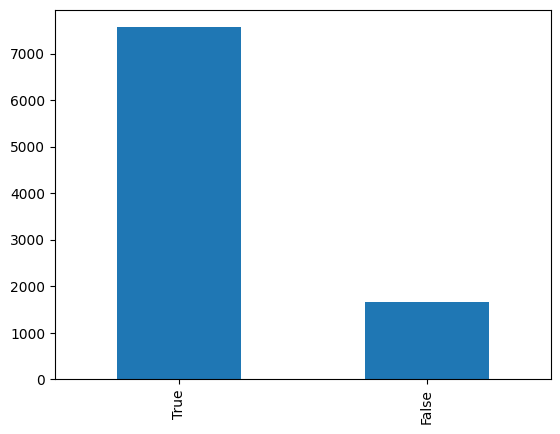

In [40]:
#Compare target class
df['voted_up'].value_counts().plot(kind='bar')

In [45]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [46]:
df_pos = df[df['voted_up']==True]
df_pos.shape

(7563, 10)

In [47]:
df_neg = df[df['voted_up']==False]
df_neg.shape

(1655, 10)

In [48]:
#Build wordcloud
wc = WordCloud(stopwords = stop_words, collocations = False, max_font_size=55, max_words=50, background_color='white')

## Word Cloud for Reviews Voted Up

(-0.5, 399.5, 199.5, -0.5)

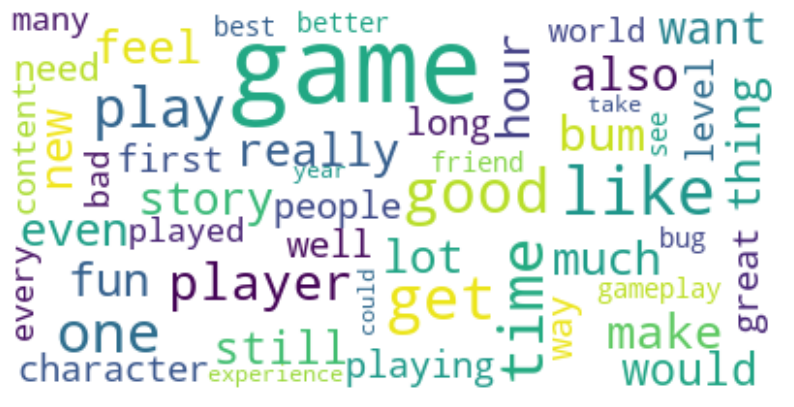

In [49]:
wc.generate(' '.join(df_pos['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Up Reviews WordCloud

## Word Cloud for Reviews Voted Down

(-0.5, 399.5, 199.5, -0.5)

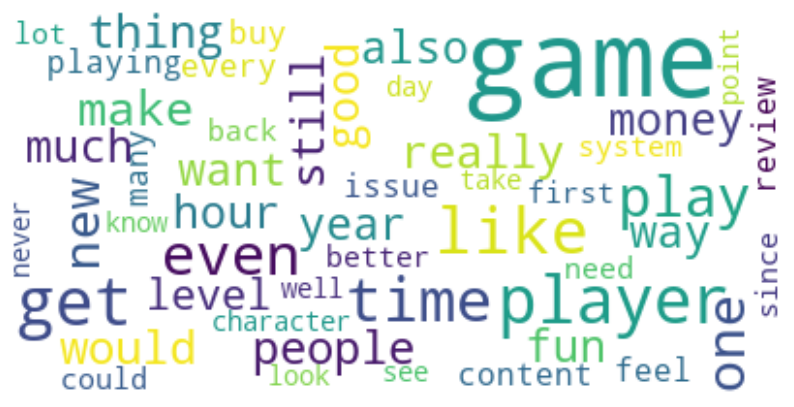

In [50]:
wc.generate(' '.join(df_neg['clean_review']))
plt.figure(figsize=(10,12))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off") #Voted Down Reviews Wordcloud

### Change Target Column to Binary -> just change bool to int()


In [51]:
df['voted_up_target'] = df['voted_up'].astype(int)

### Remove (Consecutively) Repeated Words

In [52]:
df.iloc[2] #Ex) "spoiler spoiler"

clean_review               obsessed game fan harry potter must say game waited grow plants brew potions collect tend magical beasts participate classes love adore books movies fly around broom hippogriff room requirements hogsmeade many things looking forward delivered love customize aspect gear even get started combat story much fun playing game since witcher
num_games_owned                                                                                                                                                                                                                                                                                                                                                        300
num_reviews                                                                                                                                                                                                                                                                       

In [53]:
#Use this to get rid of consecutive duplicates ONLY
df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')

#Use this to removes non-consecutive duplicates
#df['clean_review'] = (df['clean_review'].str.split()
#                              .apply(lambda x: OrderedDict.fromkeys(x).keys())
#                              .str.join(' '))


C:\Users\Brami\AppData\Local\Temp\ipykernel_17100\1395314566.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_review'] = df['clean_review'].str.replace(r'\b(\w+)(\s+\1)+\b', r'\1')


In [54]:
df.iloc[2]

clean_review               obsessed game fan harry potter must say game waited grow plants brew potions collect tend magical beasts participate classes love adore books movies fly around broom hippogriff room requirements hogsmeade many things looking forward delivered love customize aspect gear even get started combat story much fun playing game since witcher
num_games_owned                                                                                                                                                                                                                                                                                                                                                        300
num_reviews                                                                                                                                                                                                                                                                       

### Additional Feature Engineering

In [55]:
# Review Length
df['review_length'] = df['clean_review'].apply(len)

Text(0.5, 1.0, 'Distribution of Review Lengths')

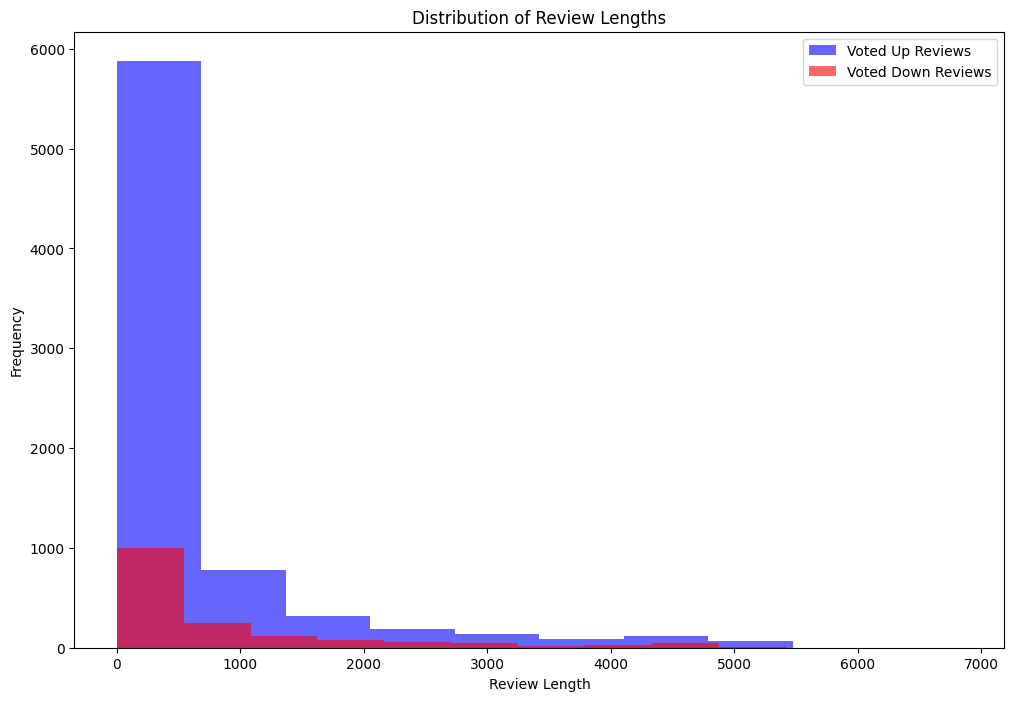

In [56]:
plt.figure(figsize=(12, 8))

df[df.voted_up_target == 1].review_length.plot(kind='hist', color='blue', 
                                       label='Voted Up Reviews', alpha=0.6)
df[df.voted_up_target == 0].review_length.plot(kind='hist', color='red', 
                                       label='Voted Down Reviews', alpha=0.6)
plt.legend()
plt.xlabel("Review Length")
plt.title('Distribution of Review Lengths')

In [57]:
#https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [58]:
### Address the Unequal Text Length Problem(?)

#### Split data into training and test set

In [59]:
df.head()

clean_review  \
1  finished first playthrough game put hours point completed content outside steam trophies personally really enjoyed game think great release everything ever wanted harry potter game story good voice acting actually phenomenal part non player characters player characters slight issue robotic voice likely due pitch nothing game breaking combat engaging though lament lack variety comes enemies confront hogwarts world represented incredible detail lost running castle taking gripes game sadly hope fixed line lack photo mode example animation issues certain foes like trolls rubberband follow player character complete animations said lack enemy variety well wish missions school focused around student life quickly feel like part time student castle lack bit classes take learn universe even student activities like quidditch wizards chess outside slight gripes game think avalanche terrific job bringing universe harry potter life game look forward future may via dlc potential similar games exploring parts wizarding world academies like ilvermorny beauxb√¢tons durmstrang even stories focused around adults universe ministries believe lot people may enjoy playing auror unspeakable   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             finally something half baked live service micro transaction infested disaster launch   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  obsessed game fan harry potter must say game waited grow plants brew potions collect tend magical beasts participate classes love adore books movies fly around broom hippogriff room requirements hogsmeade many things looking forward delivered love customize aspect gear even get started combat story much fun playing game since witcher   
4                                                                                                                                                                                                                                                                                                                                                                                                                            

In [60]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_review'], df['voted_up_target'], test_size=0.2)

### Build Model with PyTorch

In [61]:
# build vocabulary, convert text => number
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=80)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=80)

Total distinct words: 29674


In [62]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [63]:
y_train.shape

(7374,)

### Torch starts here

In [64]:
class SentimentAnalysis(torch.nn.Module):

    def __init__(self, total_word, embed_size, hidden_size, num_class, padding_index=0):
        super().__init__()
        self.total_word = total_word
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_class = num_class
        
        self.embed = torch.nn.Embedding(num_embeddings=total_word, 
                                        embedding_dim=embed_size, 
                                        padding_idx=padding_index)
        self.lstm = torch.nn.LSTM(input_size=self.embed_size, 
                                  hidden_size=self.hidden_size, 
                                  num_layers=1,
                                  bidirectional=True,
                                  batch_first=True)
        self.classifier = torch.nn.Sequential(
            # TODO: add more Linear layer, Activation layer
            torch.nn.Linear(in_features=2*self.hidden_size, out_features=num_class)
        )
        
    def forward(self, X):
        out = self.embed(X)
        out, _ = self.lstm(out)
        out = self.classifier(out[:, -1, :])
        return out

In [65]:
NUM_VOCAB = total_word
EMBED_SIZE = 128
HIDDEN_SIZE = 164
NUM_CLASS = 3
BATCH_SIZE = 64
EPOCH = 5

In [66]:
model = SentimentAnalysis(total_word=NUM_VOCAB, embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_class=NUM_CLASS)
model = model.to("cuda")

In [67]:
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [68]:
num_train = X_train.shape[0]
inds = np.arange(num_train)
for e in range(EPOCH):
    np.random.shuffle(inds)
    pbar = tqdm(range(0, X_train.shape[0], BATCH_SIZE), desc="Epoch {}".format(e+1))
    for i in pbar:
        x = torch.Tensor(X_train[inds[i:i+BATCH_SIZE]])
        x = x.type(dtype=torch.IntTensor).to("cuda")
        y_hat = model(x)
        y = torch.Tensor(y_train[inds[i:i+BATCH_SIZE]])
        y = y.type(dtype=torch.LongTensor).to("cuda")
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description("Epoch: {} - Loss: {}".format(e+1, loss.item()))

Epoch: 5 - Loss: 0.4244947135448456: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 116/116 [00:04<00:00, 25.48it/s]


### Predict

In [69]:
model.eval()
with torch.no_grad():
    x = torch.Tensor(X_test)
    x = x.type(dtype=torch.IntTensor).to("cuda")
    y_hat = model(x)

In [70]:
pred = y_hat.argmax(-1)
pred = pred.cpu().numpy()

In [71]:
print("Accuracy:", np.sum(pred == y_test)/y_test.shape[0]) #over 80% pretty good?

Accuracy: 0.8324295010845987
